Помимо классических алгоритмов векторизации, которые подсчитывают частоту встречаемости слов (мешок слов, TF-IDF), возможно использование векторных представлений, полученных с помощью языковой модели.

Для получения контекстуализированного векторного представления слова $t_k$ двунаправленная языковая модель ELMo использует конкатенацию векторов, полученных на основе обработки предшествующего контекста $t_1, ..., t_{k-1}$ и последующего контекста $t_{k+1}, \dots, t_N$.

Однако при анализе левого и правого контекста отдельно часть информации может теряться. Получить векторные представления слов, учитывая левый и правый контекст одновременно, позволяет языковая модель BERT.

## Языковая модель BERT

Появившись в 2018 году, модель BERT произвела настоящий прорыв, установив новые рекорды в большей части задач обработки текстов.

[Devlin J. et al. (2018) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805).

Модель, которая  позволяет "закодировать" каждый токен и предложение целиком, называется энкодером. BERT состоит из нескольких блоков энкодеров, каждый из которых имеет одинаковую архитектуру и принимает на вход результат предыдущего блока.

Две конфигурации: базовая (base) – 12 слоев, расширенная (large) – 24 слоя.

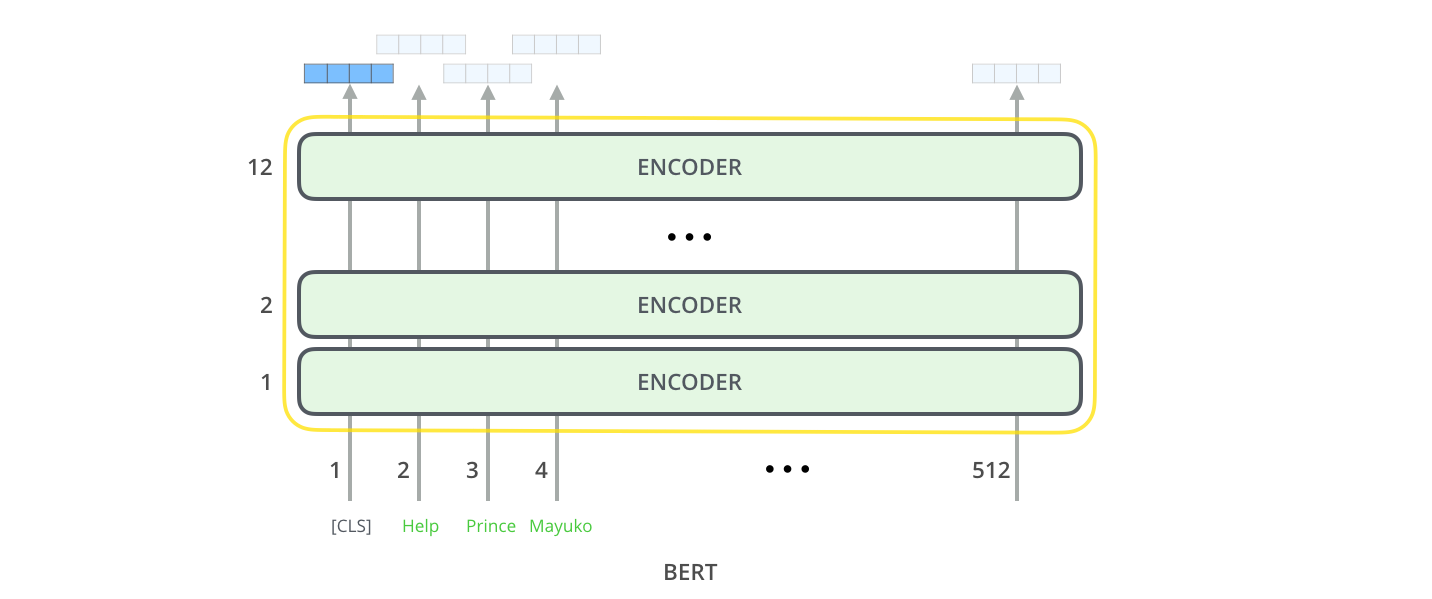

### Токенизация

Модель BERT использует метод токенизации WordPiece. Наиболее частые слова включаются в словарь целиком (слово = токен). Если слово является менее частотным и отсутствует в словаре, оно разбивается на части, которые включены в словарь (слово =  токен$_1$ + токен$_2$ + ...  + токен$_n$).

Векторное представление каждого токена содержит:
- представление самого токена
- номер его предложения
- позицию токена внутри предложения


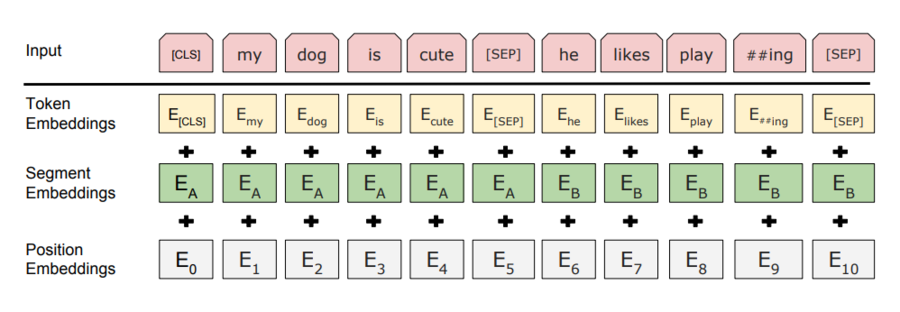

### Механизм внутреннего внимания

На вход модель получает последовательность токенов, на выходе отдает векторное представление для каждого токена, обогащенное контекстом. Входная последовательность, поступающая в энкодер, проходит через слой внутреннего внимания (self-attention). По мере того как модель обрабатывает каждое слово входной последовательности, внутреннее внимание позволяет "взглянуть" на другие слова и лучше закодировать данное слово.

Обученные модели можно скачать с помощью библиотеки [Transformers](https://huggingface.co/docs/transformers/index). Интерактивный инструмент [BertViz](https://github.com/jessevig/bertviz) позволяет визуализировать распределение внимания в языковых моделях.

In [ ]:
!pip install transformers bertviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
from bertviz import head_view
from transformers import AutoTokenizer, AutoModel

model_version = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_version)
model = AutoModel.from_pretrained(model_version, output_attentions=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
inputs = tokenizer.encode("the dog loves to play in the park", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

### Предобучение

Предобучение модели осуществляется на большом количестве неразмеченных текстовых данных.

BERT обучается одновременно на двух задачах:

- маскированное языковое моделирование (masked language modeling, MLM)

На вход BERT подаются токенизированные пары предложений, где некоторые токены скрыты — заменены на спецтокен `[MASK]`. Модель должна предсказать наиболее вероятный токен на месте маски. Обучение на задаче маскированного языкового моделирования позволяет получить контекстуализированные векторы токенов. Предобученные векторы слов можно использовать в других задачах обработки текста.

- предсказание следующего предложения (next sentence prediction, NSP)

Задача предсказания следующего предложения относится к бинарной классификации. Модель должна предсказать, является ли второе предложение продолжением первого. Предложения разделены спецтокеном `[SEP]`. За классификацию отвечает спецтокен `[CLS]`. Он содержит векторное представление обо всем предложении.

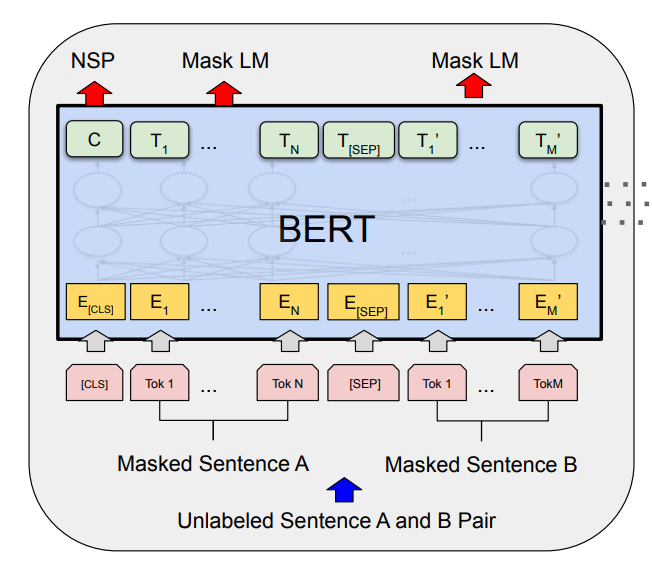

### Дообучение

Предобученные модели используются для подсчета векторных представлений слов и предложений и дообучения (fine-tuning) для целевой задачи. «Поверх» модели добавляет линейный слой. Математически может быть описан следующей формулой:

$y = activation(x * W  + b)$,

где $x$ — входные данные (вектор длины $d$),

$W$ — веса (матрица $d×k$, на которую умножается вектор),

$b$ — сдвиг (вектор длины $k$, который добавляется к выходным данным),

$activation$ — функция активации, которая применяется к выходным данным,

$y$ — выходные данные слоя (вектор длины $k$).


При классификации предложений на вход линейного слоя поступает векторное представление токена `[CLS]`. Его длина $d$ определяется свойствами модели. При умножении на матрицу весов $W$  $d$-мерный вектор преобразуется в $k$-мерный. Число $k$ определяется количеством классов для задачи ($k=2$ для бинарной классификации, $k>2$ для многоклассовой классификации).

Изначально матрица весов $W$ заполнена случайными числами. При дообучении происходит настройка весов, чтобы на целевой задаче ошибка была минимальной.

Для дообучения требуется существенно меньший объем размеченных данных (около 10000 предложений).

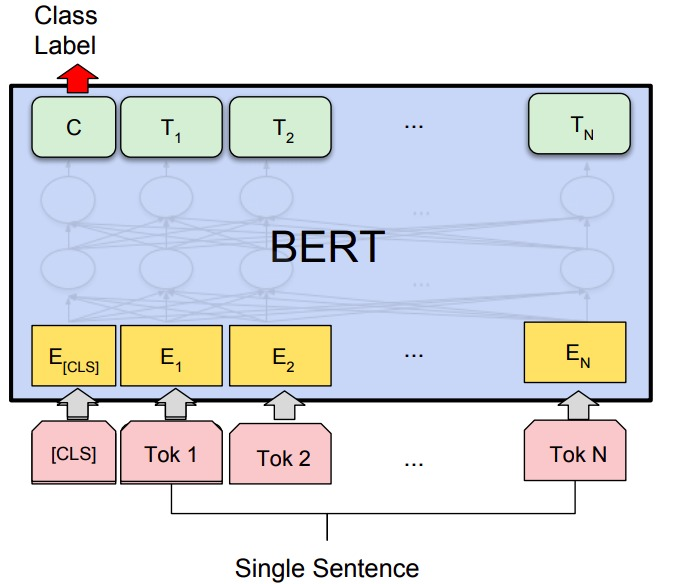

## Дистилляция знаний как метод ускорения нейронных сетей

Такие модели как BERT долго обучаются и много весят, но позволяют получить высокие оценки качества. На практике может не хватать времени и ресурсов для обучения и хранения большой модели. Однако обучение легкой модели не дает высоких показателей качества.

Легкая модель 👶🏼 — быстрая, но не точная

Продвинутая модель 👵🏻 — точная, но не быстрая

Существует способ для создания уменьшенной версии нейронных сетей – дистилляция знаний (knowledge distillation).

1. На большом объеме данных обучаем продвинутую модель 👵🏻. Можно взять заранее предобученную модель.

2. Обучаем маленькую легкую модель 👶🏼 воспроизводить предсказания большой модели 👵🏻. Используем задачу маскированного языкового моделирования. Ждем от маленькой модели 👶🏼 не предсказания правильного слова, а копирования поведения продвинутой модели 👵🏻.

Модель-ученик обучается воспроизводить предсказания модели-учителя, что достигается при использовании особой функции потерь:

$L_{student} = - \sum_i t_ilogs_i$, $t$ – предсказания учителя 👵🏻, $s$ – предсказания ученика 👶🏼.

`[CLS] The cat [MASK] on the mat`

Пусть наиболее вероятный токен на месте маски – `sat`. Но большая модель 👵🏻 знает, что в этом контексте также уместны токены `perched`, `seated`, `hopped`. Это знание полезно для обучения маленькой модели 👶🏼. Его можно передать, заставляя маленькую модель не только предсказывать высокую вероятность правильного токена `sat`, а воспроизводить всё вероятностное распределение возможных замаскированных токенов в данном тексте.

[ Sanh V. et al. (2020) DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter.](https://arxiv.org/abs/1910.01108)

DistilBERT весит на 40% меньше, чем оригинальная BERT-модель, она на 60% быстрее ее и сохраняет 97% ее функциональности. DistilBERT можно дообучить на целевую задачу и получить разумные оценки качества.

### ruBERT-tiny

Рассмотрим дистиллированный BERT для русского языка — ruBERT-tiny ([первая версия](https://huggingface.co/cointegrated/rubert-tiny), [обновленная версия](https://huggingface.co/cointegrated/rubert-tiny2)) или просто Энкодечка. Создатель этой модели — NLP-исследователь Давид Дале. Модель описана в статьях на Хабре.

[Дале Д. (2021) Маленький и быстрый BERT для русского языка.](https://habr.com/ru/articles/562064/)

[Дале Д. (2022) Рейтинг русскоязычных энкодеров предложений.](https://habr.com/ru/articles/669674/)

В качестве модели-ученика взят [мультиязычный BERT](https://huggingface.co/bert-base-multilingual-cased), чтобы модель понимала и русский, и английский. Словарь этой модели содержит 120 000 токенов, но были отобраны только 30 000, которые часто встречаются в русском и английском языках. Размер эмбеддинга сокращен с 768 до 312, число слоёв – с 12 до 3.

Маленький русскоязычный BERT был создан в первую очередь для классификации коротких текстов. Он должен уметь построить хорошее векторное представление предложения. В качестве учителей для дистилляции были выбраны модели, которые с этим хорошо справляются:
- RuBERT ([статья](https://arxiv.org/abs/1905.07213), [модель](https://huggingface.co/DeepPavlov/rubert-base-cased-sentence))

Мультиязычная модель BERT‑base была дообучена на русской части Википедии и новостных данных.

- LaBSE ([статья](https://arxiv.org/abs/2007.01852), [модель](https://huggingface.co/sentence-transformers/LaBSE))

Модель LaBSE (language-agnostic BERT sentence embeddings) обучалась на выборке текстов на 100+ языков. Основная задача – сближать друг с другом векторы предложений с одинаковым смыслом на разных языках.

- Laser ([статья](https://arxiv.org/abs/1812.10464), [пакет](https://pypi.org/project/laserembeddings/))

- USE ([статья](https://arxiv.org/abs/1803.11175), [код](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3))

LASER (Language-Agnostic SEntence Representations) и USE (Universal Sentence Encoder) — это инструменты для вычисления векторов предложений.

Помимо предсказания замаскированных токенов, веткор токена `[CLS]` модели-ученика должен предсказывать векторы предложений, полученные из этих четырёх моделей. Дополнительно модель обучалась на задачу translation ranking (как LaBSE): вектор предложения на русском языке должен быть ближе к вектору его перевода на английский, чем к вектору остальных примеров в батче.

В качестве обучающей выборки взято три параллельных корпуса англо-русских предложений: от [Яндекс.Переводчика](https://translate.yandex.ru/corpus), [OPUS-100](https://huggingface.co/datasets/opus100) и [Tatoeba](https://huggingface.co/datasets/tatoeba), суммарно 2,5 млн коротких текстов.

RuBERT-tiny2 – это доработанная версия ruBERT-tiny: расширен словарь модели c 30 000 до 80 000 токенов, увеличена максимальная длина текста с 512 до 2048 токенов.

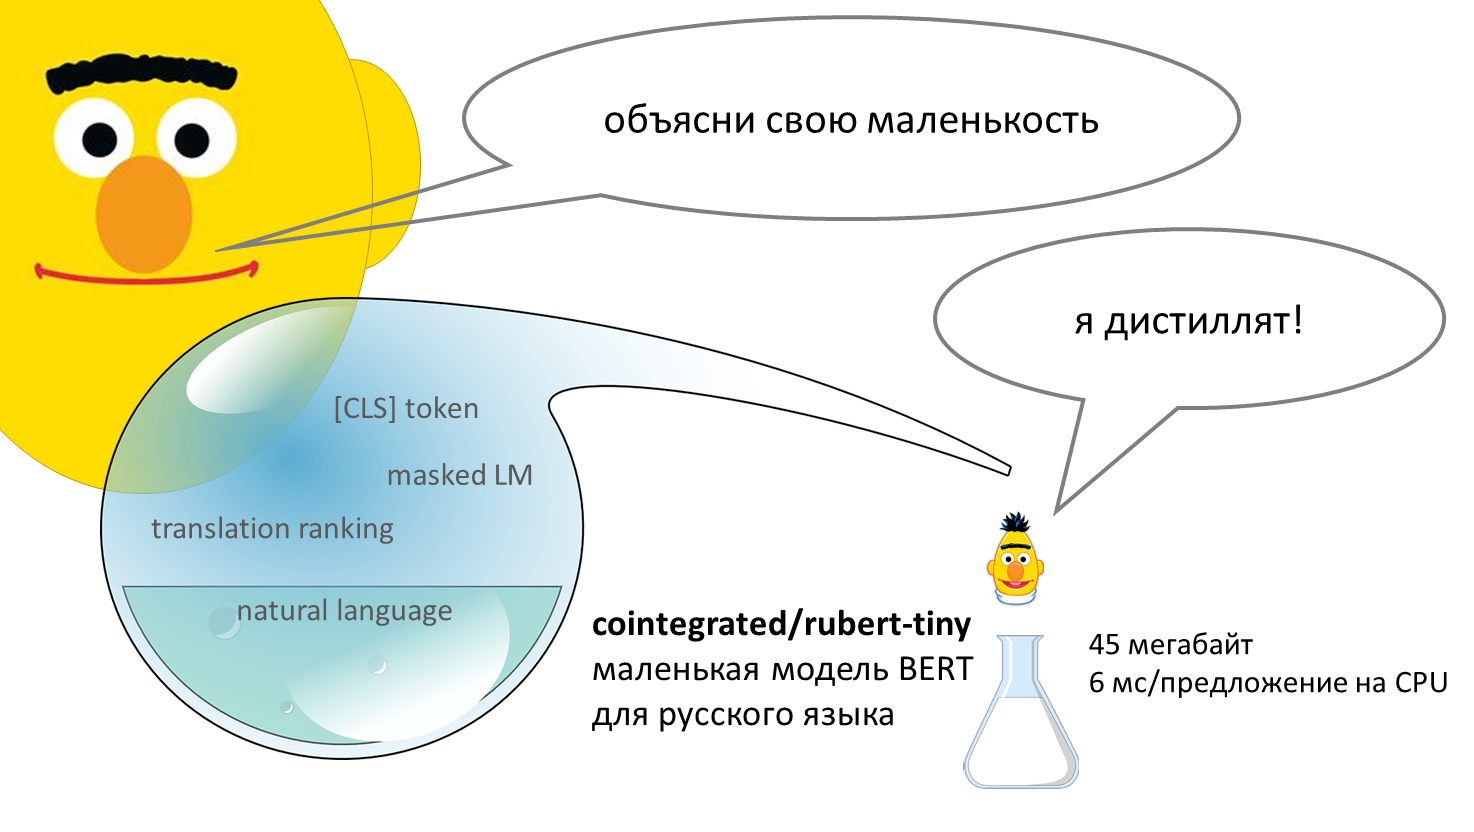

## Дооучение ruBERT-tiny2 для распознавания эмоций

Будем осуществлять дообучение модели ruBERT-tiny2 для распознавания эмоций на корпусе CEDR.

Загрузим необходимые библиотеки.

In [ ]:
!pip install transformers sentencepiece datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


### Загрузка токенизатора и модели

Будем хранить модель на видеокарте, если она доступна. Это позволит ускорить вычисления.

- Если `torch.cuda.is_available() = True`, мы будем использовать CUDA (Compute Unified Device Architecture) для вычислений.

- Если `torch.cuda.is_available() = False`, вычисления будут производиться на CPU (central processing unit).

Чтобы выполнять вычисления на видеокарте, нужно зайти в раздел "Среда выполнения" -> "Сменить среду выполнения", выбрать аппаратный ускоритель T4 GPU
 (графический процессор).

In [ ]:
import torch
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


Скачаем токенизатор и модель [ruBERT-tiny2](https://huggingface.co/cointegrated/rubert-tiny2) с помощью библиотеки Transformers. Для этого указываем идентификатор модели и используем метод `from_pretrained`.

Загрузка токенизатора осуществляется с помощью автоматического класса [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer). Для загрузки модели используется класс [AutoModelForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification): он уже содержит линейный слой поверх предобученной модели, который нужен для дообучения. Необходимо указать количество классов (`num_labels`) и тип задачи (`problem_type`):  каждому объекту присваивается одна метка (`single_label_classification`)  или несколько (`multi_label_classification`).

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

base_model = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=6, problem_type='multi_label_classification').to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

### Загрузка данных

Загрузим уже известный нам корпус [CEDR](https://huggingface.co/datasets/cedr) (основная версия).

In [ ]:
from datasets import load_dataset

cedr = load_dataset('cedr')

README.md:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/757k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/188k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7528 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1882 [00:00<?, ? examples/s]

In [ ]:
cedr

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 7528
    })
    test: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 1882
    })
})

При работе с моделью BERT предобработка осуществляется с помощью токенизатора. Он позволяет преобразовать токены в индексы в соответствии со словарем модели.

📌 Запишите в переменную `sent` текст какого-либо предложения набора данных. Примените токенизатор к этому предложению и запишите результат в переменную `tokenized_sent`. Какое преобразование осуществляется с предложением?

In [ ]:
# Место для вашего кода
sent = cedr['train'][1]['text']
tokenized_sent = tokenizer(sent)
print(sent)
print(tokenized_sent)

Так, обнаружено несколько проблем с дисплеем (выгорание, странные зеленые полосы), дефекты динамика и некорректная работа Face ID.
{'input_ids': [2, 5849, 16, 37054, 3910, 11456, 329, 67660, 12, 67239, 2677, 16, 45270, 50034, 36616, 13, 16, 70268, 15997, 320, 38172, 18355, 8703, 7641, 6816, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Посмотрим, какие индексы в словаре соответствуют словам, с помощью метода  `convert_ids_to_tokens`.

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_sent["input_ids"])

['[CLS]',
 'Так',
 ',',
 'обнаружено',
 'несколько',
 'проблем',
 'с',
 'дисплеем',
 '(',
 'выгора',
 '##ние',
 ',',
 'странные',
 'зеленые',
 'полосы',
 ')',
 ',',
 'дефекты',
 'динамика',
 'и',
 'некоррек',
 '##тная',
 'работа',
 'Face',
 'ID',
 '.',
 '[SEP]']

### Преобразование меток класса

В описании датасета указано следующее соотношение эмоций и числовых меток:

`{0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}`

Однако нейтральному классу соответствует пустой список. Кроме того, у одного предложения может быть сразу несколько меток.

In [ ]:
cedr["train"][130]

{'text': 'Боярский известен как ярый футбольный болельщик.',
 'labels': [],
 'source': 'lenta'}

In [ ]:
cedr["train"][131]

{'text': 'Ударилась сильно рукой, я боюсь в троллейбусах ездить(',
 'labels': [1, 3],
 'source': 'twitter'}

Будем считать, что изначальные метки сдвинуты на единицу, поскольку добавлен нейтральный класс (0 – без эмоций, 1 – радость, 2 – печаль, 3 – удивление, 4 – страх, 5 – злость). Определим заданное соответствие названий классов и меток в параметре `config`.



In [ ]:
LABELS = ['no_emotion', 'joy', 'sadness', 'surprise', 'fear', 'anger']
model.config.label2id = {label: i for i, label in enumerate(LABELS)}
print(model.config.label2id)
model.config.id2label = {i: label for i, label in enumerate(LABELS)}
print(model.config.id2label)

{'no_emotion': 0, 'joy': 1, 'sadness': 2, 'surprise': 3, 'fear': 4, 'anger': 5}
{0: 'no_emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger'}


Для обучения модели необходимо перевести метки из списка в векторы.

📌 Напишем функцию `binarize_labels`:
- на вход поступает список с числовыми метками класса
- создается два новых списка
  - первый имеет длину 1:
     - содержит единицу, если изначальная метка объекта является пустым списком,
     - содержит ноль в противном случае;
  - второй имеет длину 5 и содержит единицу на тех позициях, которые указаны в списке меток
- два получившихся списка конкатенируются (складываются)

In [ ]:
# Место для вашего кода

def binarize_labels(labels):
    if len(labels)==0:
      a = [1]
    else:
      a = [0]
    b = []
    for i in range(5):
      if i in labels:
        b.append(1)
      else:
        b.append(0)
    return a + b

#def binarize_labels(labels):
#    return [int(len(labels)==0)] + [int(i in labels) for i in range(5)]

Для проверки функции можно подать на вход несколько разных списков: пустой или с числами от 0 до 4.

In [ ]:
print(binarize_labels([]))
print(binarize_labels([0]))
print(binarize_labels([1, 4]))

[1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1]


### Обработка данных

С помощью метода `map` можно применить описанные выше преобразования ко всем объектам датасета:
- применить токенизатор к текстам, включая усечение до максимальной длины входных данных модели (`truncation=True`)
- преобразовать числовые метки классов в векторы из нулей и единиц, удалив лишние столбцы (`remove_columns=['text', 'labels', 'source']`)

In [ ]:
cedr_mapped = cedr.map(lambda x: tokenizer(x['text'], truncation=True), batched=True).map(lambda x: {'label': [float(y) for y in binarize_labels(x['labels'])]}, batched=False, remove_columns=['text', 'labels', 'source'])

Map:   0%|          | 0/7528 [00:00<?, ? examples/s]

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

Map:   0%|          | 0/7528 [00:00<?, ? examples/s]

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

In [ ]:
cedr_mapped

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 7528
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 1882
    })
})

Отделим от обучающей выборки 300 объектов, которые будут использоваться для валидации.

In [ ]:
splitted = cedr_mapped['train'].train_test_split(test_size=300, seed=42)
splitted

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 7228
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 300
    })
})

При обучении нейронных сетей данные делят на части – батчи, и пропускают их через сеть по очереди. Внутри одного батча предложения должны иметь одинаковую длину. Этого можно добиться с помощью паддинга – более короткие предложения принудительно "удлиняются" за счет добавления нулей в список индексов. Для разбиения на батчи и паддинга используется класс [DataCollatorWithPadding](DataCollatorWithPadding).

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

Объект класса [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) — итератор, который позволяет создавать новые батчи.

Создадим `train_dataloader` — экземпляр класса `DataLoader`. Он принимает на вход  обучающую выборку `splitted['train']`, размер батча `batch_size`, значение параметра `shuffle` (при `True` данные перемешиваются каждую эпоху), функцию для разбиения на батчи `collate_fn`.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(
    splitted['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

📌 По аналогии создайте `dev_dataloader` для валидационной выборки.

In [ ]:
# Место для вашего кода
dev_dataloader = DataLoader(
    splitted['test'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

Посмотрим, как выглядит первая выдача `train_dataloader` в цикле.

In [ ]:
data = next(iter(train_dataloader))
print(f'Батч:\n{data.keys()}\n')
print(f"Индексы токенов:\n{data['input_ids'].shape}\nbatch size x max len\n")
print(f"Индексы токенов:\n{data['token_type_ids'].shape}\nbatch size x max len\n")
print(f"Маски внимания:\n{data['attention_mask'].shape}\nbatch size x max len\n")
print(f"Метки классов:\n{data['labels'].shape}\nbatch size x num classes\n")

Батч:
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Индексы токенов:
torch.Size([64, 48])
batch size x max len

Индексы токенов:
torch.Size([64, 48])
batch size x max len

Маски внимания:
torch.Size([64, 48])
batch size x max len

Метки классов:
torch.Size([64, 6])
batch size x num classes



### Обучение

Функция `predict_with_model` используется для записи предсказанных моделью ответов, возвращает истинные метки `facts` и предсказания `preds`. Библиотека `tqdm` используется для создания индикаторов прогресса (progressbar) и отображения количества итераций и затраченного времени.

In [ ]:
import numpy as np
from tqdm.auto import tqdm

def predict_with_model(model, dataloader):
    preds = []
    facts = []

    for batch in tqdm(dataloader): # проход по батчам в цикле
        facts.append(batch.labels.cpu().numpy()) # атрибут labels содержит правильные ответы
        batch = batch.to(model.device) # модель и данные должны храниться в одном месте: CPU или CUDA
        # модель применяется к батчу
        with torch.no_grad():
            pr = model(input_ids=batch.input_ids, attention_mask=batch.attention_mask, token_type_ids=batch.token_type_ids)
        # к предсказаниям применяется функция активации softmax
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())

    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

Для оценки качества модели на валидационной выборке используется [AUC-ROC ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)— площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах:

- True Positive Rate (TPR) — полнота (recall) или чувствительность (sensitivity). Показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

$$TPR = \frac{TP}{TP + FN}$$
- False Positive Rate (FPR) — специфичность (specificity). Показывает, какую долю из объектов отрицательного класса алгоритм предсказал неверно.
$$FPR = \frac{FP}{FP + TN}$$

Необходимо вычислить метрики и построить их на одном графике с осями FPR и TPR. Результирующая кривая представляет собой кривую ROC, а площадь под кривой является метрикой AUC-ROC.

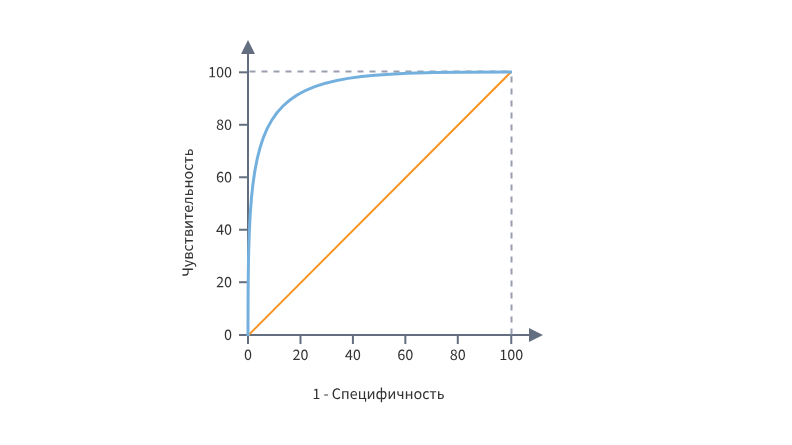

В идеальном случае, когда классификатор не делает ошибок (FPR = 0, TPR = 1), площадь под кривой равна единице. Когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к 0.5, так как классификатор будет выдавать одинаковое количество TP и FP.

В случае многометочной классификации создается $K$ бинарных классификаторов ($K$ — количество классов), поэтому AUC-ROC для каждого рассчитывается отдельно.

📌 Допишите, как с помощью предыдущей функции получить истинные и предсказанные ответы.

In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate_model(model, dev_dataloader):
    facts, preds = predict_with_model(model, dev_dataloader) # Место для вашего кода
    # подсчитываем AUC-ROC для каждого класса
    aucs = [roc_auc_score(facts[:, i], preds[:, i]) for i in range(6)]
    return aucs, np.mean(aucs)

Перед началом обучения модели необходимо определить некоторые дополнительные параметры.

In [ ]:
# алгоритм оптимизации функции потерь и скорость обучения
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
# значение шага для вывода результатов
report_step = 10000

Процесс обучения выполняется циклом длиной в количество эпох — полных проходов через обучающий набор данных:


*  Прямое распространение: модель применяется к данным с текущими весами.
*  Путем сравнения предсказанного значения с истинным ответом вычисляется значение функции потерь.
*  Ищем градиент – направление максимального роста функции потерь при текущих весах.
*  Обратное распространение: обновляем веса, перемещаясь по функции потерь в обратном градиенту направлении.


In [ ]:
from tqdm.auto import trange

model.train()

for epoch in trange(30):
    tq = tqdm(train_dataloader)

    # проход по батчам в цикле
    for i, batch in enumerate(tq):

        # модель и данные должны храниться в одном месте: CPU или CUDA
        batch = batch.to(model.device)
        # модель применяется к батчу
        output = model(**batch)
        # считаем значение функции потерь
        loss = output.loss
        # считаем градиенты по всем параметрам модели
        loss.backward()

        # после прохода по каждому батчу кроме нулевого происходит обновление весов с помощью шага оптимизатора
        if i != 0:
            # обновление весов
            optimizer.step()
            # обнуление градиентов
            optimizer.zero_grad()

        # после каждого 10000-го батча выводятся значения метрик
        if i % report_step == 0:
            model.eval()
            aucs, eval_loss = evaluate_model(model, dev_dataloader)
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {loss.item():4.4f}  val auc: {eval_loss}')
            print('aucs', aucs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, step 0: train loss: 0.6948  val auc: 0.4578008399150953
aucs [0.2824691814026502, 0.3298678795754819, 0.6196584127855135, 0.5593542260208927, 0.29528985507246375, 0.6601654846335697]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1, step 0: train loss: 0.4881  val auc: 0.6921218967748715
aucs [0.8524400941871738, 0.6593747743845209, 0.8652170930790863, 0.7094017094017093, 0.5164553140096618, 0.5498423955870764]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 2, step 0: train loss: 0.4230  val auc: 0.7647261003534443
aucs [0.8991181494990536, 0.7582846003898636, 0.9112421976815968, 0.8169854836521504, 0.6647041062801933, 0.5380220646178093]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 3, step 0: train loss: 0.3790  val auc: 0.7653084381085608
aucs [0.9113070778890993, 0.792217168435492, 0.9382673708759175, 0.7332790666123999, 0.6354166666666667, 0.5813632781717888]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 4, step 0: train loss: 0.3714  val auc: 0.7896846984898499
aucs [0.9320836603721316, 0.8614540466392319, 0.9556896906509362, 0.7361280694614027, 0.6641002415458936, 0.5886524822695035]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 5, step 0: train loss: 0.2976  val auc: 0.817305495410083
aucs [0.9414562075811441, 0.9080210815103602, 0.9684477673365801, 0.7971781305114638, 0.6837258454106281, 0.6050039401103231]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 6, step 0: train loss: 0.3246  val auc: 0.83225998734935
aucs [0.9463964171937763, 0.9270088802252545, 0.9722203168941628, 0.7992131325464659, 0.732487922705314, 0.6162332545311269]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 7, step 0: train loss: 0.2685  val auc: 0.8551291680447678
aucs [0.9484279052587838, 0.941737058696123, 0.9729748268056795, 0.8302808302808301, 0.7732487922705313, 0.6641055949566588]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 8, step 0: train loss: 0.2620  val auc: 0.8631301294944639
aucs [0.9497668405743571, 0.9483791783986716, 0.9756499074010563, 0.8476461809795143, 0.7981582125603864, 0.6591804570527975]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 9, step 0: train loss: 0.2532  val auc: 0.8663775428152287
aucs [0.9509210951567477, 0.9554544798209514, 0.9748953974895398, 0.8670465337132005, 0.8049516908212561, 0.6449960598896769]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 10, step 0: train loss: 0.1988  val auc: 0.868448874470447
aucs [0.9525832217553903, 0.9520612230163887, 0.9763358255024349, 0.8703025369692037, 0.8191425120772946, 0.64026792750197]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 11, step 0: train loss: 0.2046  val auc: 0.8757005817642874
aucs [0.9528602428551642, 0.9592087213919572, 0.9771589272240894, 0.8910595577262244, 0.8342391304347827, 0.6396769109535068]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 12, step 0: train loss: 0.1888  val auc: 0.8807882913347506
aucs [0.9524447112055034, 0.9662118258609487, 0.9768159681734, 0.9034052367385701, 0.8396739130434783, 0.6461780929866037]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 13, step 0: train loss: 0.2120  val auc: 0.8875730712753035
aucs [0.953368114871416, 0.9594975092051116, 0.977364702654503, 0.9004205670872337, 0.8826992753623188, 0.6520882584712372]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 14, step 0: train loss: 0.2144  val auc: 0.8881474660560454
aucs [0.955722794219493, 0.9607970543643058, 0.9785307634268469, 0.8925518925518926, 0.896286231884058, 0.6449960598896768]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 15, step 0: train loss: 0.1744  val auc: 0.8935395693326661
aucs [0.954614709820398, 0.9615912208504801, 0.9791480897180876, 0.897028897028897, 0.9144021739130435, 0.6544523246650906]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 16, step 0: train loss: 0.1314  val auc: 0.8972853837416239
aucs [0.9522138602890253, 0.9614468269439028, 0.9783249879964332, 0.9067969067969067, 0.9153079710144927, 0.6696217494089834]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 17, step 0: train loss: 0.1219  val auc: 0.896826890926573
aucs [0.9528602428551641, 0.9598584939715544, 0.9801083750600179, 0.9050332383665718, 0.9219504830917874, 0.661150512214342]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 18, step 0: train loss: 0.1192  val auc: 0.8995797732586815
aucs [0.952860242855164, 0.9598584939715544, 0.9803827423005693, 0.9080179080179082, 0.9224033816425121, 0.6739558707643813]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 19, step 0: train loss: 0.1621  val auc: 0.8978689818450526
aucs [0.9516598180894779, 0.95855894881236, 0.9811372522120858, 0.892958892958893, 0.9242149758454107, 0.6786840031520883]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 20, step 0: train loss: 0.1509  val auc: 0.8992792194372793
aucs [0.9505517336903828, 0.9592809183452458, 0.9820289457438782, 0.8959435626102292, 0.9240640096618357, 0.6838061465721039]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 21, step 0: train loss: 0.1599  val auc: 0.8988980973214864
aucs [0.9505517336903828, 0.957909176232763, 0.9818231703134646, 0.894722561389228, 0.9249698067632849, 0.6834121355397951]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 22, step 0: train loss: 0.1365  val auc: 0.9024245817209149
aucs [0.9520753497391385, 0.9586311457656488, 0.9819603539337403, 0.9038122371455705, 0.9242149758454107, 0.6938534278959811]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 23, step 0: train loss: 0.0926  val auc: 0.9058797246061383
aucs [0.9485664158086707, 0.9587033427189372, 0.9808628849715344, 0.9135802469135802, 0.9257246376811594, 0.7078408195429472]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 24, step 0: train loss: 0.1123  val auc: 0.901109773602245
aucs [0.9484740754420795, 0.9588477366255144, 0.9813430276424995, 0.8917378917378916, 0.9270833333333333, 0.6991725768321514]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 25, step 0: train loss: 0.1311  val auc: 0.9051393349957326
aucs [0.9481277990673623, 0.9578369792794744, 0.9814116194526374, 0.8937728937728937, 0.9264794685990337, 0.7232072498029944]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 26, step 0: train loss: 0.0770  val auc: 0.9039408658529552
aucs [0.9509441802483956, 0.9581979640459172, 0.9831950065162219, 0.8916022249355583, 0.924969806763285, 0.7147360126083531]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 27, step 0: train loss: 0.0682  val auc: 0.9109552623298544
aucs [0.9479200332425319, 0.9579813731860516, 0.9799025996296042, 0.9127662460995793, 0.926026570048309, 0.7411347517730497]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 28, step 0: train loss: 0.1036  val auc: 0.9067492880032845
aucs [0.9507825846068608, 0.9582701609992058, 0.98003978324988, 0.8922805589472257, 0.9278381642512078, 0.7312844759653271]


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 29, step 0: train loss: 0.0779  val auc: 0.9108403924430556
aucs [0.9505979038736784, 0.9579813731860515, 0.9799711914397421, 0.9080179080179079, 0.927536231884058, 0.7409377462568951]


### Тестирование

Преобразуем тестовый набор данных в объект класса DataLoader. Запишем предсказания обученной модели на тестовых данных.

In [ ]:
test_dataloader = DataLoader(
    cedr_mapped['test'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

In [ ]:
model.eval()
facts, preds = predict_with_model(model, test_dataloader)

  0%|          | 0/30 [00:00<?, ?it/s]

Метрики качества на корпусе CEDR определяются двумя способами:
- микро- и макроусредненная F-мера для каждой эмоции
- точность, полнота и F-мера для каждого класса

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Микро- и макроусредненные значения F-меры для каждого бинарного классификатора

binary_report = pd.DataFrame([
    {av: f1_score(facts[:, i], preds[:, i] > 0.5, average=av) for av in ['micro', 'macro']}
    for i in range(6)
]).round(2)
binary_report.loc[len(binary_report), ['micro','macro']] = binary_report['micro'].mean(), binary_report['macro'].mean()
binary_report = binary_report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'mean'})
binary_report.style.format(precision=2)

,micro,macro
no emotion,0.85,0.85
joy,0.94,0.90
sadness,0.93,0.89
surprise,0.94,0.82
fear,0.95,0.83
anger,0.93,0.66
mean,0.92,0.83


In [ ]:
# Значения точности, полноты и F-меры для каждого класса

class_report = pd.DataFrame([
    {precision_score(facts[:, i], preds[:, i] > 0.5),
     recall_score(facts[:, i], preds[:, i] > 0.5),
     f1_score(facts[:, i], preds[:, i] > 0.5)}
    for i in range(6)
    ], ).round(2)
mean_report = pd.DataFrame([
    {precision_score(facts[:,:6], preds[:,:6] > 0.5, average=av), recall_score(facts[:,:6], preds[:,:6] > 0.5, average=av), f1_score(facts[:,:6], preds[:,:6] > 0.5, average=av)}
    for av in ['micro', 'macro', 'weighted', 'samples']
]).round(2)
report = pd.concat([class_report, mean_report], ignore_index=True)
report = report.rename(columns={0: "precision", 1: "recall", 2: "f1_score"})
report = report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'micro', 7: 'macro', 8: 'weighted', 9: 'samples'})
report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1_score
no emotion,0.81,0.82,0.81
joy,0.84,0.84,0.84
sadness,0.81,0.84,0.83
surprise,0.72,0.62,0.67
fear,0.70,0.65,0.68
anger,0.46,0.30,0.36
micro,0.79,0.76,0.77
macro,0.72,0.68,0.70
weighted,0.78,0.76,0.77
samples,0.77,0.76,0.77


### Загрузка и тестирование модели из Hugging Face

📌 Скачайте [модель ruBERT-tiny, обученную для распознавания эмоций на корпусе CEDR](https://huggingface.co/cointegrated/rubert-tiny2-cedr-emotion-detection).

In [ ]:
cedr_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection") # Место для вашего кода
cedr_model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2-cedr-emotion-detection") # Место для вашего кода

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

📌 Запишите предсказания модели на тестовом наборе данных.

In [ ]:
model.eval()
cedr_facts, cedr_preds = predict_with_model(cedr_model, test_dataloader) # Место для вашего кода

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# Микро- и макроусредненные значения F-меры для каждого бинарного классификатора

binary_report = pd.DataFrame([
    {av: f1_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5, average=av) for av in ['micro', 'macro']}
    for i in range(6)
]).round(2)
binary_report.loc[len(binary_report), ['micro','macro']] = binary_report['micro'].mean(), binary_report['macro'].mean()
binary_report = binary_report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'mean'})
binary_report.style.format(precision=2)

,micro,macro
no emotion,0.86,0.86
joy,0.94,0.90
sadness,0.94,0.90
surprise,0.95,0.84
fear,0.96,0.84
anger,0.93,0.68
mean,0.93,0.84


In [ ]:
# Значения точности, полноты и F-меры для каждого класса

class_report = pd.DataFrame([
    {precision_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5),
     recall_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5),
     f1_score(cedr_facts[:, i], cedr_preds[:, i] > 0.5)}
    for i in range(6)
    ], ).round(2)
mean_report = pd.DataFrame([{precision_score(cedr_facts[:,:6], cedr_preds[:,:6] > 0.5, average=av),
     recall_score(cedr_facts[:,:6], cedr_preds[:,:6] > 0.5, average=av),
     f1_score(cedr_facts[:,:6], cedr_preds[:,:6] > 0.5, average=av)}
    for av in ['micro', 'macro', 'weighted', 'samples']
]).round(2)
report = pd.concat([class_report, mean_report], ignore_index=True)
report = report.rename(columns={0: "precision", 1: "recall", 2: "f1_score"})
report = report.rename(index={0: 'no emotion', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'anger', 6: 'micro', 7: 'macro', 8: 'weighted', 9: 'samples'})
report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1_score
no emotion,0.81,0.84,0.83
joy,0.87,0.79,0.83
sadness,0.83,0.85,0.84
surprise,0.71,0.69,0.70
fear,0.75,0.65,0.69
anger,0.44,0.38,0.40
micro,0.79,0.78,0.78
macro,0.74,0.70,0.72
weighted,0.79,0.78,0.78
samples,0.78,0.78,0.78
